用 [`MovieLens`](https://grouplens.org/datasets/movielens/) 数据集做电影推荐

# 数据集

## 1. 下载并解压数据集

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib
import os

def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [2]:
data_dir = './'
download_extract('ml-1m', data_dir)

Found ml-1m Data


## 2. 数据集长什么样

MovieLens 1M 数据集包含6000个用户在近4000部电影上的1亿条评论。

数据集分为三个文件：用户数据users.dat，电影数据movies.dat和评分数据ratings.dat。

### 用户数据

| 用户ID | 性别 | 年龄 | 职业ID | 邮编 |
|:---:|:---:|:---:|:---:|:---:|
| UserID | Gender | Age | Occupation | Zip-code |

UserID、Gender、Age和Occupation都是类别字段，其中邮编字段我们不用。

- 性别 Gender："M"(male)男性，"F"(female)女性
- 年龄 Age: 

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- 职业 Occupation：

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [3]:
import pandas as pd

In [4]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### 电影数据

| 电影ID | 电影名 | 电影风格 |
|:---:|:---:|:---:|
| MovieID | Title | Genres |

MovieID是类别字段，Title是文本，Genres也是类别字段

- 电影名格式为 IMDB (包含年份)
- 电影风格:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [5]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### 评分数据
| 用户ID | 电影ID | 评分 | 时间戳 |
|:---:|:---:|:---:|:---:|
| UserID | MovieID | Rating | Timestamp |

评分字段Rating就是我们要学习的targets，时间戳字段我们不用。

- 1 <= UserIDs <= 6040
- 1 <= MovieIDs <= 3952
- 评分 Ratings 是 5星制
- 时间戳 Timestamp 单位是秒
- 每个用户至少有 20 个评分

In [6]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 3. 清洗数据
总的来说，id不变，枚举型字段用one-hot编号，字符串型字段统一长度后做文本嵌入。

用户
- UserID、Occupation不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。

电影
- MovieID不用变。
- Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

In [7]:
#读取User数据
users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users = users.filter(regex='UserID|Gender|Age|JobID')
users_orig = users.values
#改变User数据中性别和年龄
gender_map = {'F':0, 'M':1}
users['Gender'] = users['Gender'].map(gender_map)

age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
users['Age'] = users['Age'].map(age_map)
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [8]:
#读取Movie数据集
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies_orig = movies.values
#将Title中的年份去掉
import re
pattern = re.compile(r'^(.*)\((\d+)\)$')

title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
movies['Title'] = movies['Title'].map(title_map)

#电影类型转数字字典
genres_set = set()
for val in movies['Genres'].str.split('|'):
    genres_set.update(val)

genres_set.add('<PAD>')
genres2int = {val:ii for ii, val in enumerate(genres_set)}

#将电影类型转成等长数字列表，长度是18
genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

for key in genres_map:
    for cnt in range(max(genres2int.values()) - len(genres_map[key])):
        genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])

movies['Genres'] = movies['Genres'].map(genres_map)

#电影Title转数字字典
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val)

title_set.add('<PAD>')
title2int = {val:ii for ii, val in enumerate(title_set)}

#将电影Title转成等长数字列表，长度是15
title_count = 15
title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}

for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])

movies['Title'] = movies['Title'].map(title_map)
movies.head()

,MovieID,Title,Genres
0,1,"[2605, 570, 422, 422, 422, 422, 422, 422, 422,...","[5, 7, 4, 15, 15, 15, 15, 15, 15, 15, 15, 15, ..."
1,2,"[4439, 422, 422, 422, 422, 422, 422, 422, 422,...","[13, 7, 9, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."
2,3,"[68, 1944, 1424, 422, 422, 422, 422, 422, 422,...","[4, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."
3,4,"[2876, 2592, 3918, 422, 422, 422, 422, 422, 42...","[4, 11, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
4,5,"[3205, 2316, 4876, 4018, 2956, 4901, 422, 422,...","[4, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."


In [9]:
#读取评分数据集
ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings = ratings.filter(regex='UserID|MovieID|ratings')
ratings.head()

,UserID,MovieID,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [10]:
#合并三个表
data = pd.merge(pd.merge(ratings, users), movies)

#将数据分成X和y两张表
target_fields = ['ratings']
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]

features = features_pd.values
targets_values = targets_pd.values

In [11]:
import pickle

def save(params, filename='params.p'):
    pickle.dump(params, open(filename, 'wb'))

def load(filename='params.p'):
    return pickle.load(open(filename, mode='rb'))

save((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), "data.p")
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load("data.p")

## 4. 划分数据集

In [12]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [13]:
from sklearn.model_selection import train_test_split
#将数据集分成训练集和测试集，随机种子不固定
train_X,test_X, train_y, test_y = train_test_split(features,  
                                                   targets_values,  
                                                   test_size = 0.2,  
                                                   random_state = 0)  

In [14]:
# 看一下数据，等下用这个数据来 debug 模型对不对
batch_size=5
train_batches = get_batches(train_X, train_y, batch_size)
x, y = next(train_batches)
x, y

(array([[752, 1836, 0, 6, 3,
         list([4518, 3811, 2316, 111, 2712, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422]),
         list([11, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])],
        [3470, 2396, 1, 1, 17,
         list([4272, 739, 5136, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422]),
         list([4, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])],
        [424, 1959, 1, 6, 17,
         list([730, 2316, 2855, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422]),
         list([11, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])],
        [1663, 3148, 1, 4, 4,
         list([2648, 3956, 182, 2712, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422]),
         list([11, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])],
        [2507, 3396, 1, 6, 4,
         list([3953, 1985, 2712, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422]),
         list([7, 4

# 推荐模型

<img src="assets/model.001.jpeg"/>

In [15]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.uid = nn.Sequential(
            nn.Embedding(uid_max, embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
        ) 
        self.user_gender = nn.Sequential(
            nn.Embedding(gender_max, embed_dim // 2),
            nn.Linear(embed_dim // 2, embed_dim),
            nn.ReLU(),
        ) 
        self.user_age = nn.Sequential(
            nn.Embedding(age_max, embed_dim // 2),
            nn.Linear(embed_dim // 2, embed_dim),
            nn.ReLU(),
        ) 
        self.user_job = nn.Sequential(
            nn.Embedding(job_max, embed_dim // 2),
            nn.Linear(embed_dim // 2, embed_dim),
            nn.ReLU(),
        )
        self.user_combine_flat = nn.Linear(4*embed_dim, 200)

        self.movie_id = nn.Sequential(
            nn.Embedding(movie_id_max, embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
        ) 
        self.movie_categories = nn.Sequential(
            nn.Embedding(movie_categories_max, embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
        ) 
        self.movie_titles = nn.Embedding(movie_title_max, embed_dim)
        self.movie_titles_conv_1 = nn.Sequential(
            nn.Conv2d(1, filter_num, kernel_size=(2,embed_dim)),
            nn.ReLU(),
            nn.MaxPool2d((sentences_size - 2 + 1, 1),)
        ) 
        self.movie_titles_conv_2 = nn.Sequential(
            nn.Conv2d(1, filter_num, kernel_size=(3,embed_dim)),
            nn.ReLU(),
            nn.MaxPool2d((sentences_size - 3 + 1, 1),)
        ) 
        self.movie_titles_conv_3 = nn.Sequential(
            nn.Conv2d(1, filter_num, kernel_size=(4,embed_dim)),
            nn.ReLU(),
            nn.MaxPool2d((sentences_size - 4 + 1, 1),)
        ) 
        self.movie_titles_conv_4 = nn.Sequential(
            nn.Conv2d(1, filter_num, kernel_size=(5,embed_dim)),
            nn.ReLU(),
            nn.MaxPool2d((sentences_size - 5 + 1, 1),)
        )
        self.movie_combine_flat = nn.Linear(3*embed_dim, 200)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def embed_user(self, uid, user_gender, user_age, user_job):
        uid_embed = self.uid(uid)  # B x d
        user_gender_embed = self.user_gender(user_gender)  # B x d
        user_age_embed = self.user_age(user_age)  # B x d
        user_job_embed = self.user_job(user_job)  # B x d
        user_combine = torch.cat([uid_embed, user_gender_embed, user_age_embed, user_job_embed], dim=-1)  # B x 4d
        user_combine_flat = self.user_combine_flat(user_combine).tanh().view(-1, 200) # B x 200
        return user_combine_flat
    
    def embed_movie(self, movie_id, movie_categories, movie_titles):
        movie_id_embed = self.movie_id(movie_id)  # B x d
        movie_categories_embed = self.movie_categories(movie_categories)  # B x N x d, N is the num of categories count
        movie_categories_embed = movie_categories_embed.sum(dim=1).view(-1, embed_dim)  # B x d
        movie_titles_embed = self.movie_titles(movie_titles)  # B x L x d, L is the length of title
        movie_titles_embed = movie_titles_embed.unsqueeze(dim=1)
        movie_titles_embed_1 = self.movie_titles_conv_1(movie_titles_embed)
        movie_titles_embed_2 = self.movie_titles_conv_2(movie_titles_embed)
        movie_titles_embed_3 = self.movie_titles_conv_3(movie_titles_embed)
        movie_titles_embed_4 = self.movie_titles_conv_4(movie_titles_embed)
        movie_titles_embed = torch.cat([movie_titles_embed_1, movie_titles_embed_2, movie_titles_embed_3, movie_titles_embed_4], dim=-1)
        movie_titles_embed = self.dropout(movie_titles_embed.view(-1, embed_dim))
        movie_combine = torch.cat([movie_id_embed, movie_categories_embed, movie_titles_embed], dim=-1)
        movie_combine_flat = self.movie_combine_flat(movie_combine).view(-1, 200) # B x 200
        return movie_combine_flat
    
    def forward(self, 
                uid, user_gender, user_age, user_job,
                movie_id, movie_categories, movie_titles,
               ):
        user_combine_flat = self.embed_user(uid, user_gender, user_age, user_job)
        movie_combine_flat = self.embed_movie(movie_id, movie_categories, movie_titles)
        
        inference = (user_combine_flat * movie_combine_flat).sum(dim=-1, keepdim=True) # B x 1
        return inference

In [20]:
# debug 一下，看 Net 写得对不对
net = Net()

categories = np.zeros([batch_size, 18])
for i in range(batch_size):
    categories[i] = x.take(6,1)[i]

titles = np.zeros([batch_size, sentences_size])
for i in range(batch_size):
    titles[i] = x.take(5,1)[i]

uid = torch.LongTensor(list(x.take(0,1))).view(batch_size)
user_gender = torch.LongTensor(list(x.take(2,1))).view(batch_size)
user_age = torch.LongTensor(list(x.take(3,1))).view(batch_size)
user_job = torch.LongTensor(list(x.take(4,1))).view(batch_size)
movie_id = torch.LongTensor(list(x.take(1,1))).view(batch_size)
movie_categories = torch.LongTensor(categories)  #x.take(6,1)
movie_titles = torch.LongTensor(titles)  #x.take(5,1)

targets = torch.FloatTensor(list(y)).view(batch_size)

y_ = net(uid, user_gender, user_age, user_job, 
        movie_id, movie_categories, movie_titles)
y_.shape # 应该输出 (batch_size, 1)

torch.Size([5, 1])

In [21]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

In [23]:
import datetime

losses = {'train':[], 'test':[]}

net = Net().cuda()
loss_function = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch_i in range(num_epochs):
    #将数据集分成训练集和测试集，随机种子不固定
    train_X,test_X, train_y, test_y = train_test_split(features,  
                                                       targets_values,  
                                                       test_size = 0.2,  
                                                       random_state = 0)  

    train_batches = get_batches(train_X, train_y, batch_size)
    test_batches = get_batches(test_X, test_y, batch_size)

    #训练的迭代，保存训练损失
    for batch_i in range(len(train_X) // batch_size):
        x, y = next(train_batches)

        categories = np.zeros([batch_size, 18])
        for i in range(batch_size):
            categories[i] = x.take(6,1)[i]

        titles = np.zeros([batch_size, sentences_size])
        for i in range(batch_size):
            titles[i] = x.take(5,1)[i]

        categories = np.zeros([batch_size, 18])
        for i in range(batch_size):
            categories[i] = x.take(6,1)[i]

        titles = np.zeros([batch_size, sentences_size])
        for i in range(batch_size):
            titles[i] = x.take(5,1)[i]

        uid = torch.LongTensor(list(x.take(0,1))).view(batch_size)
        user_gender = torch.LongTensor(list(x.take(2,1))).view(batch_size)
        user_age = torch.LongTensor(list(x.take(3,1))).view(batch_size)
        user_job = torch.LongTensor(list(x.take(4,1))).view(batch_size)
        
        movie_id = torch.LongTensor(list(x.take(1,1))).view(batch_size)
        movie_categories = torch.LongTensor(categories)  #x.take(6,1)
        movie_titles = torch.LongTensor(titles)  #x.take(5,1)

        targets = torch.FloatTensor(list(y)).view(batch_size, 1)
        
        predict = net(uid.cuda(), user_gender.cuda(), user_age.cuda(), user_job.cuda(), movie_id.cuda(), movie_categories.cuda(), movie_titles.cuda())
        train_loss = loss_function(predict, targets.cuda())
        opt.zero_grad()
        train_loss.backward()
        opt.step()
        losses['train'].append(train_loss.item())
        

        # Show every <show_every_n_batches> batches
        if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
            time_str = datetime.datetime.now().isoformat()
            print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                time_str,
                epoch_i,
                batch_i,
                (len(train_X) // batch_size),
                train_loss))

    #使用测试数据的迭代
    for batch_i  in range(len(test_X) // batch_size):
        x, y = next(test_batches)

        categories = np.zeros([batch_size, 18])
        for i in range(batch_size):
            categories[i] = x.take(6,1)[i]

        titles = np.zeros([batch_size, sentences_size])
        for i in range(batch_size):
            titles[i] = x.take(5,1)[i]

        uid = torch.LongTensor(list(x.take(0,1))).view(batch_size)
        user_gender = torch.LongTensor(list(x.take(2,1))).view(batch_size)
        user_age = torch.LongTensor(list(x.take(3,1))).view(batch_size)
        user_job = torch.LongTensor(list(x.take(4,1))).view(batch_size)
        
        movie_id = torch.LongTensor(list(x.take(1,1))).view(batch_size)
        movie_categories = torch.LongTensor(categories)  #x.take(6,1)
        movie_titles = torch.LongTensor(titles)  #x.take(5,1)

        targets = torch.FloatTensor(list(y)).view(batch_size, 1)

        predict = net(uid.cuda(), user_gender.cuda(), user_age.cuda(), user_job.cuda(), movie_id.cuda(), movie_categories.cuda(), movie_titles.cuda())
        test_loss = loss_function(predict, targets.cuda())

        #保存测试损失
        losses['test'].append(test_loss)

        time_str = datetime.datetime.now().isoformat()
        if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
            print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                time_str,
                epoch_i,
                batch_i,
                (len(test_X) // batch_size),
                test_loss))

2021-10-06T22:56:31.722894: Epoch   0 Batch    0/3125   train_loss = 51.113
2021-10-06T22:56:32.374308: Epoch   0 Batch   20/3125   train_loss = 10.568
2021-10-06T22:56:33.023391: Epoch   0 Batch   40/3125   train_loss = 5.786
2021-10-06T22:56:33.725418: Epoch   0 Batch   60/3125   train_loss = 3.268
2021-10-06T22:56:34.420563: Epoch   0 Batch   80/3125   train_loss = 2.737
2021-10-06T22:56:35.091240: Epoch   0 Batch  100/3125   train_loss = 2.088
2021-10-06T22:56:35.777013: Epoch   0 Batch  120/3125   train_loss = 1.872
2021-10-06T22:56:36.437497: Epoch   0 Batch  140/3125   train_loss = 1.979
2021-10-06T22:56:37.123193: Epoch   0 Batch  160/3125   train_loss = 1.567
2021-10-06T22:56:37.706064: Epoch   0 Batch  180/3125   train_loss = 1.773
2021-10-06T22:56:38.370484: Epoch   0 Batch  200/3125   train_loss = 2.052
2021-10-06T22:56:38.940628: Epoch   0 Batch  220/3125   train_loss = 1.843
2021-10-06T22:56:39.559224: Epoch   0 Batch  240/3125   train_loss = 1.461
2021-10-06T22:56:40.209

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.92 GiB total capacity; 10.24 GiB already allocated; 1.50 MiB free; 10.24 GiB reserved in total by PyTorch)

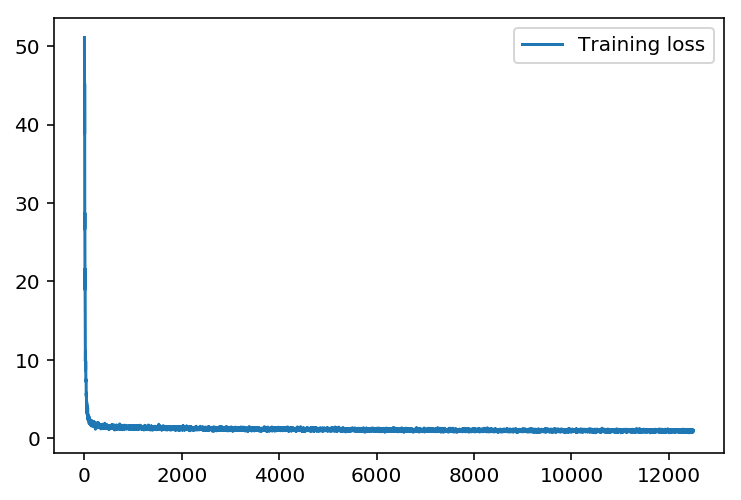

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
# 训练Loss
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

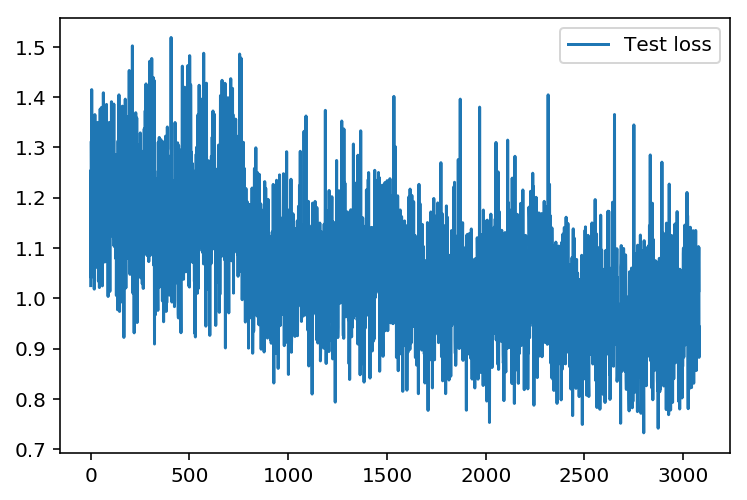

In [26]:
# 测试Loss
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

# 使用模型进行推荐

In [27]:
net.eval()

Net(
  (uid): Sequential(
    (0): Embedding(6041, 32)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (user_gender): Sequential(
    (0): Embedding(2, 16)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): ReLU()
  )
  (user_age): Sequential(
    (0): Embedding(7, 16)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): ReLU()
  )
  (user_job): Sequential(
    (0): Embedding(21, 16)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): ReLU()
  )
  (user_combine_flat): Linear(in_features=128, out_features=200, bias=True)
  (movie_id): Sequential(
    (0): Embedding(3953, 32)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (movie_categories): Sequential(
    (0): Embedding(19, 32)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (movie_titles): Embedding(5215, 32)
  (movie_titles_conv_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(2, 

## 缓存用户嵌入

In [45]:
users_matrics = []
for x in users.values:
    uid = torch.LongTensor([x.take(0)]).view(1).cuda()
    user_gender = torch.LongTensor([x.take(1)]).view(1).cuda()
    user_age = torch.LongTensor([x.take(2)]).view(1).cuda()
    user_job = torch.LongTensor([x.take(3)]).view(1).cuda()

    user_combine_layer_flat_val = net.embed_user(uid, user_gender, user_age, user_job).detach().cpu().numpy()
    users_matrics.append(user_combine_layer_flat_val)
users_matrics = np.array(users_matrics).reshape(-1, 200)
save(users_matrics, 'users_matrics.p')
users_matrics = load('users_matrics.p')

## 缓存电影嵌入

In [44]:
movie_matrics = []
for x in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = x.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = x.take(1)

    movie_id = torch.LongTensor([x.take(0)]).view(1).cuda()
    movie_categories = torch.LongTensor(categories).cuda()
    movie_titles = torch.LongTensor(titles).cuda()

    movie_combine_layer_flat_val = net.embed_movie(movie_id, movie_categories, movie_titles).detach().cpu().numpy()
    movie_matrics.append(movie_combine_layer_flat_val)
movie_matrics = np.array(movie_matrics).reshape(-1, 200)
save(movie_matrics, 'movie_matrics.p')
movie_matrics = load('movie_matrics.p')

## 评分

In [49]:
def rating_movie(user_id_val, movie_id_val):
    
    uid = torch.LongTensor([users.values[user_id_val-1][0]]).view(1,1).cuda()
    user_gender = torch.LongTensor([users.values[user_id_val-1][1]]).view(1,1).cuda()
    user_age = torch.LongTensor([users.values[user_id_val-1][2]]).view(1,1).cuda()
    user_job = torch.LongTensor([users.values[user_id_val-1][3]]).view(1,1).cuda()
    
    categories = np.zeros([1, 18])
    categories[0] = movies.values[movieid2idx[movie_id_val]][2]

    titles = np.zeros([1, sentences_size])
    titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
    movie_id = torch.LongTensor([x.take(0)]).view(1).cuda()
    movie_categories = torch.LongTensor(categories).cuda()
    movie_titles = torch.LongTensor(titles).cuda()
    inference_val = net(uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles)
    return inference_val

## 开始推荐电影

### 推荐同类型的电影

计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [57]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    norm_movie_matrics = torch.sqrt(torch.sum(torch.square(torch.Tensor(movie_matrics)), 1, keepdim=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    #推荐同类型的电影
    probs_embeddings = torch.Tensor(movie_matrics[movieid2idx[movie_id_val]]).view([1, 200])
    probs_similarity = torch.matmul(probs_embeddings, normalized_movie_matrics.T)
    sim = (probs_similarity)
#     results = (-sim[0]).argsort()[0:top_k]
#     print(results)

    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / torch.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results
    
recommend_same_type_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
3490
[3559 'Limelight (1952)' 'Drama']
3396
[3465 "That's Life! (1986)" 'Drama']
391
[395 'Desert Winds (1995)' 'Drama']
1872
[1941 'Hamlet (1948)' 'Drama']
785
[795 'Somebody to Love (1994)' 'Drama']


{391, 785, 1872, 3396, 3490}

### 推荐您喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [58]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):
    #推荐您喜欢的电影
    probs_embeddings = torch.Tensor(users_matrics[user_id_val-1]).view([1, 200])

    probs_similarity = torch.matmul(probs_embeddings, torch.Tensor(movie_matrics).T)
    sim = (probs_similarity)

    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / torch.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results
    
recommend_your_favorite_movie(234, 10)

以下是给您的推荐：
736
[746 'Force of Evil (1948)' 'Film-Noir']
553
[557 'Mamma Roma (1962)' 'Drama']
847
[858 'Godfather, The (1972)' 'Action|Crime|Drama']
598
[602 'Great Day in Harlem, A (1994)' 'Documentary']
3835
[3905 'Specials, The (2000)' 'Comedy']


{553, 598, 736, 847, 3835}

### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [74]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    probs_movie_embeddings = torch.Tensor(movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = torch.matmul(probs_movie_embeddings, torch.Tensor(users_matrics).T)
    favorite_user_id = np.argsort(probs_user_favorite_similarity)[0][-top_k:]

    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))

    print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
    probs_users_embeddings = torch.Tensor(users_matrics[favorite_user_id-1]).view(-1, 200)
    probs_similarity = torch.matmul(probs_users_embeddings, torch.Tensor(movie_matrics).T)
    sim = probs_similarity
    p = np.argmax(sim, 1)
    print("喜欢看这个电影的人还喜欢看：")

    results = set()
    while len(results) != 5:
        c = p[random.randrange(top_k)]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results
    
recommend_other_favorite_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[3802 'M' 18 0]
 [5042 'F' 18 2]
 [3031 'M' 18 4]
 [567 'M' 35 20]
 [3406 'F' 25 7]
 [3213 'F' 25 1]
 [3576 'M' 50 7]
 [5503 'F' 25 9]
 [1568 'F' 1 10]
 [1268 'M' 50 2]
 [4754 'F' 18 0]
 [3780 'M' 1 0]
 [4658 'M' 25 4]
 [4775 'M' 25 17]
 [2696 'M' 25 7]
 [4085 'F' 25 6]
 [985 'M' 25 4]
 [5309 'M' 25 0]
 [5079 'M' 25 4]
 [5833 'F' 35 0]]
喜欢看这个电影的人还喜欢看：
tensor(553)
[557 'Mamma Roma (1962)' 'Drama']
tensor(553)
[557 'Mamma Roma (1962)' 'Drama']
tensor(553)
[557 'Mamma Roma (1962)' 'Drama']
tensor(553)
[557 'Mamma Roma (1962)' 'Drama']
tensor(553)
[557 'Mamma Roma (1962)' 'Drama']


{tensor(553), tensor(553), tensor(553), tensor(553), tensor(553)}